## Install GitPython

We will use GitPython to analyze the commit history of the NumPy GitHub repository.


In [1]:
!pip install gitpython

  Using cached gitdb-4.0.12-py3-none-any.whl.metadata (1.2 kB)
  Using cached smmap-5.0.2-py3-none-any.whl.metadata (4.3 kB)
Using cached gitdb-4.0.12-py3-none-any.whl (62 kB)
Using cached smmap-5.0.2-py3-none-any.whl (24 kB)



[notice] A new release of pip is available: 25.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## Clone the NumPy GitHub Repository

We clone the `numpy/numpy` repository locally. GitPython will be used to explore its commit history.

In [2]:
import git
import os

if not os.path.exists("numpy"):
    print("cloning NumPy repo...")
    git.Repo.clone_from("https://github.com/numpy/numpy.git", "numpy")
else:
    print("Repository already cloned.")

cloning NumPy repo...


## Extract Code Churn from Commit History

We will collect the number of lines added and deleted for each commit using GitPython, then group the data by month to analyze trends over time.

In [4]:
from datetime import datetime
import pandas as pd

# Load the repo
repo = git.Repo("numpy")

# Parse commit data
data = []

for commit in repo.iter_commits():
    stats = commit.stats.total
    data.append({
        "date": datetime.fromtimestamp(commit.committed_date),
        "insertions": stats.get("insertions", 0),
        "deletions": stats.get("deletions", 0),
    })

# Create DataFrame
df = pd.DataFrame(data)
df["month"] = df["date"].dt.to_period("M")

# Group by month (only numeric columns)
monthly_churn = df.groupby("month")[["insertions", "deletions"]].sum().reset_index()
monthly_churn["month"] = monthly_churn["month"].astype(str)

monthly_churn.head()

,month,insertions,deletions
0,2001-12,1914,46
1,2002-01,90283,3126
2,2002-02,2918,856
3,2002-03,4943,129
4,2002-04,8079,3734


In [7]:
monthly_churn.head(20)

,month,insertions,deletions
0,2001-12,1914,46
1,2002-01,90283,3126
2,2002-02,2918,856
3,2002-03,4943,129
4,2002-04,8079,3734
5,2002-05,435,167
6,2002-06,6423,2801
7,2002-07,107,35
8,2002-08,573,393
9,2002-09,42043,14797


In [25]:
monthly_churn.to_csv("../data/monthly_churn.csv", index=False)

## Visualize Code Churn Over Time

We now plot the monthly number of lines added and deleted to observe code churn patterns in the NumPy project over time. The figure will also be saved in the `plots/` folder.


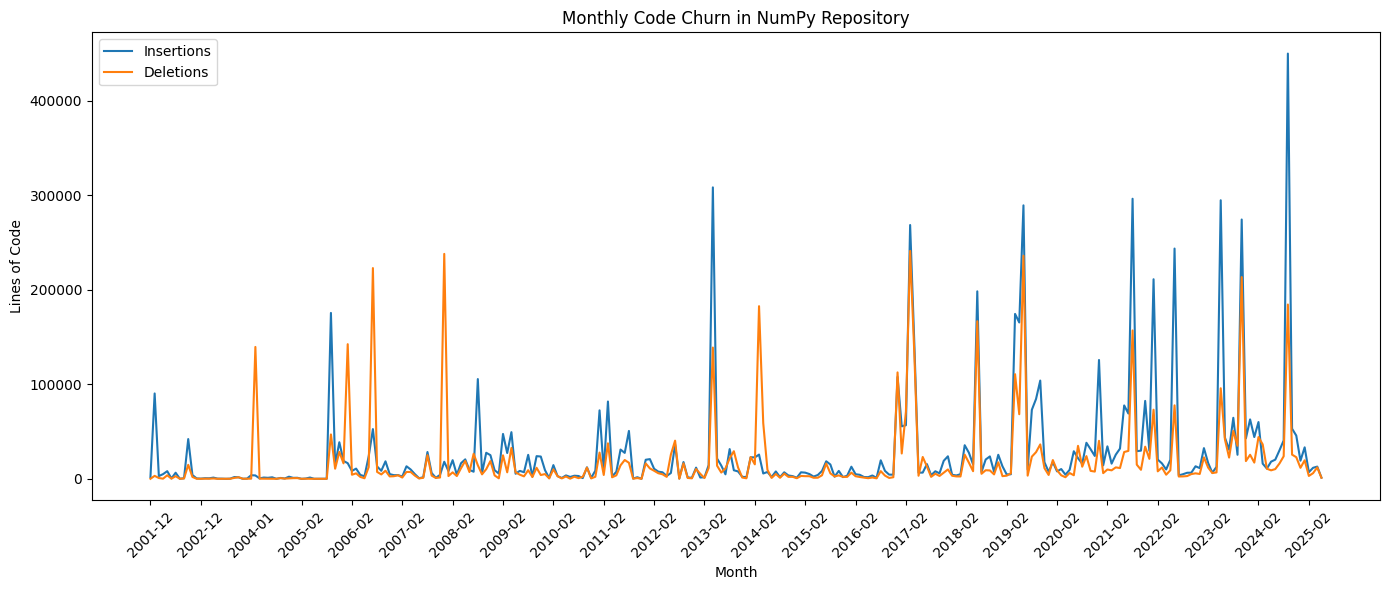

In [10]:
import matplotlib.pyplot as plt

# Plot insertions/deletions with cleaner x-axis
plt.figure(figsize=(14, 6))
plt.plot(monthly_churn["month"], monthly_churn["insertions"], label="Insertions", linewidth=1.5)
plt.plot(monthly_churn["month"], monthly_churn["deletions"], label="Deletions", linewidth=1.5)

# Improve x-axis: show 1 label every 12 months
xticks_to_show = monthly_churn["month"][::12]  # every 12th month
plt.xticks(ticks=xticks_to_show.index, labels=xticks_to_show, rotation=45)

plt.xlabel("Month")
plt.ylabel("Lines of Code")
plt.title("Monthly Code Churn in NumPy Repository")
plt.legend()
plt.tight_layout()
plt.savefig("../plots/churn_over_time.png")
plt.show()


> ### Plot 2 – Net Code Churn per Month

This bar chart shows the monthly difference between lines added and removed (net churn). Positive values indicate code expansion; negative values may reflect refactorings or code cleanup.


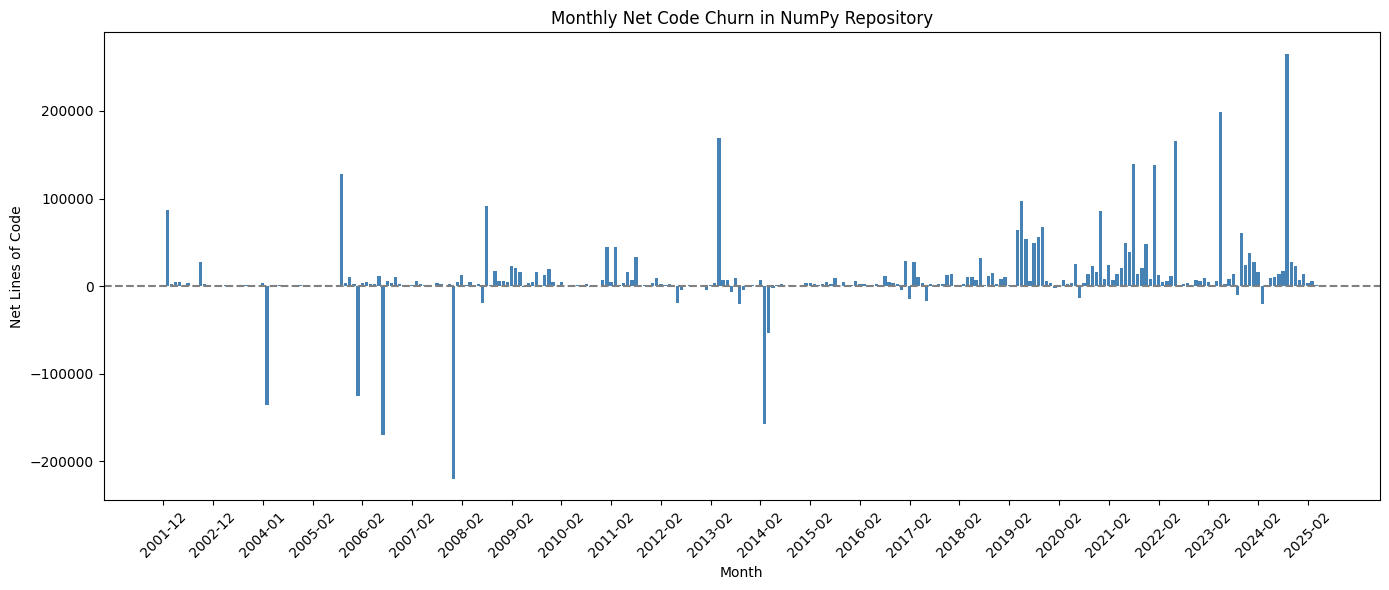

In [12]:
# Compute net churn
monthly_churn["net_churn"] = monthly_churn["insertions"] - monthly_churn["deletions"]

# Plot net churn
plt.figure(figsize=(14, 6))
plt.bar(monthly_churn["month"], monthly_churn["net_churn"], color="steelblue")
plt.axhline(0, color="gray", linestyle="--")
plt.xlabel("Month")
plt.ylabel("Net Lines of Code")
plt.title("Monthly Net Code Churn in NumPy Repository")

# Improve x-axis readability
xticks_to_show = monthly_churn["month"][::12]
plt.xticks(ticks=xticks_to_show.index, labels=xticks_to_show, rotation=45)

plt.tight_layout()
plt.savefig("../plots/net_churn_barplot.png")
plt.show()


> ### Plot 3 – Distribution of Monthly Code Churn (Boxplot)

This boxplot illustrates the distribution and spread of monthly insertions and deletions. It highlights months with extremely high churn as statistical outliers.


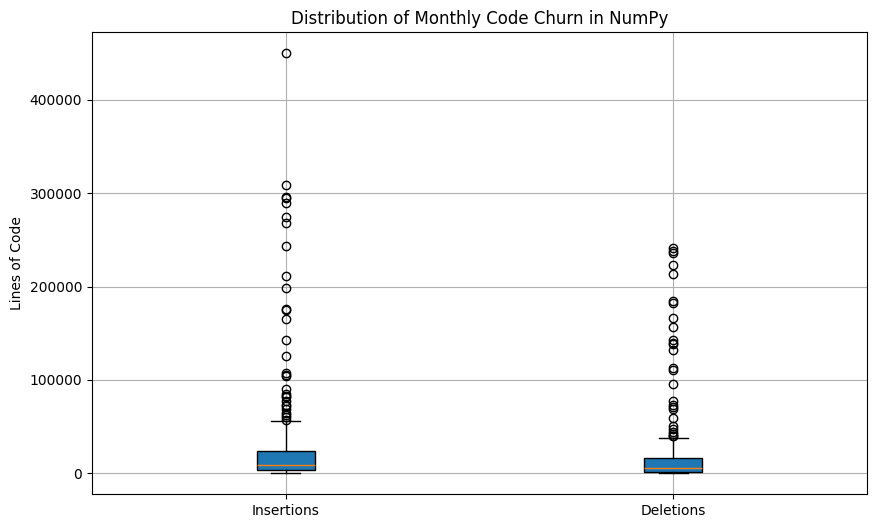

In [15]:
plt.figure(figsize=(10, 6))
plt.boxplot([monthly_churn["insertions"], monthly_churn["deletions"]],
            tick_labels=["Insertions", "Deletions"],
            patch_artist=True)

plt.title("Distribution of Monthly Code Churn in NumPy")
plt.ylabel("Lines of Code")
plt.grid(True)

plt.savefig("../plots/churn_boxplot.png")
plt.show()


> ### Plot 4 – Heatmap of Monthly Code Churn (Insertions)

This heatmap displays the number of lines added per month across different years. Darker cells indicate months with higher development activity.


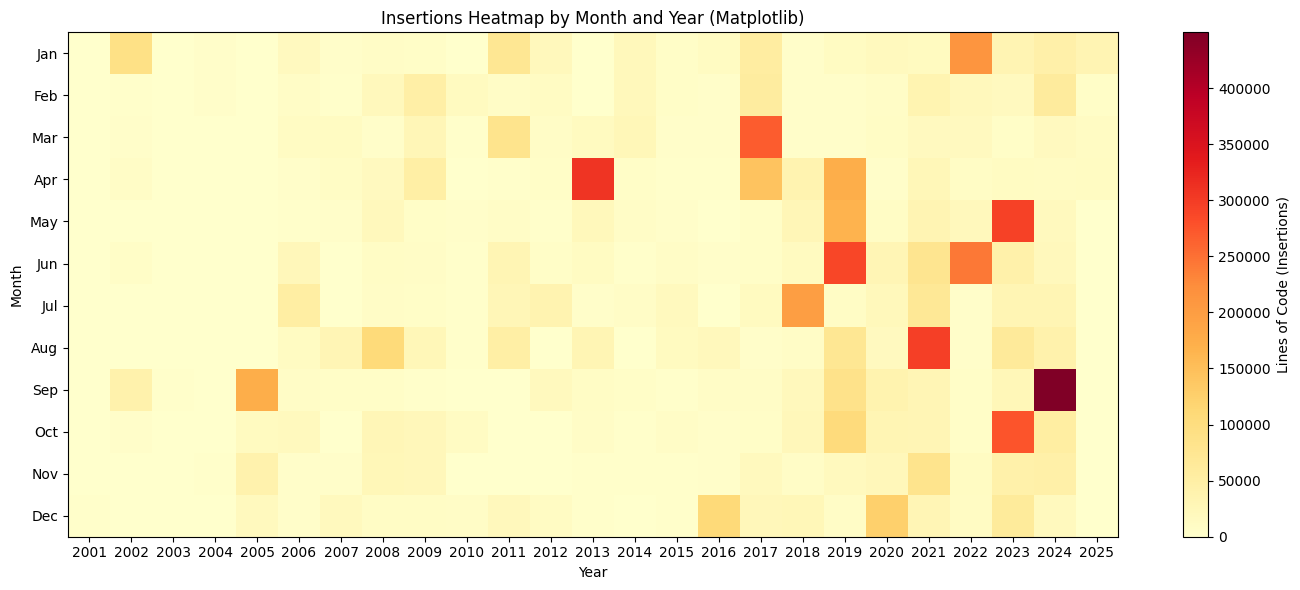

In [26]:
import matplotlib.pyplot as plt
import numpy as np

# Group insertions by year and month
monthly_churn["year"] = pd.to_datetime(monthly_churn["month"]).dt.year
monthly_churn["month_num"] = pd.to_datetime(monthly_churn["month"]).dt.month

# Create pivot table manually
pivot_table = monthly_churn.pivot_table(index="month_num", columns="year", values="insertions", fill_value=0)

# Convert to numpy array
data = pivot_table.values

# Plot with matplotlib
plt.figure(figsize=(14, 6))
plt.imshow(data, aspect="auto", cmap="YlOrRd")

# Axes labels
plt.title("Insertions Heatmap by Month and Year (Matplotlib)")
plt.xlabel("Year")
plt.ylabel("Month")

# X-axis: year labels
plt.xticks(ticks=np.arange(len(pivot_table.columns)), labels=pivot_table.columns)

# Y-axis: month labels
plt.yticks(ticks=np.arange(12), labels=[
    "Jan", "Feb", "Mar", "Apr", "May", "Jun",
    "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"
])

plt.colorbar(label="Lines of Code (Insertions)")
plt.tight_layout()
plt.savefig("../plots/insertions_heatmap_alt.png")
plt.show()


## Extract Commit-Level Data

We extract detailed information from each commit: author name, timestamp, number of files changed, list of modified files, and code churn metrics. The data is saved in the `data/commits.csv` file.


In [27]:
# extract detailed commit data
full_data = []

for commit in repo.iter_commits():
    stats = commit.stats
    full_data.append({
        "author": commit.author.name,
        "date": datetime.fromtimestamp(commit.committed_date),
        "num_files_changed": len(stats.files),
        "files": list(stats.files.keys()),
        "insertions": stats.total.get("insertions", 0),
        "deletions": stats.total.get("deletions", 0)
    })

# create DataFrame and save
commits_df = pd.DataFrame(full_data)
commits_df.to_csv("../data/commits.csv", index=False)

print("Full commit-level data exported to: data/commits.csv")

Full commit-level data exported to: data/commits.csv


> #### Checking on Commit Data

We perform basic verification to ensure that our extracted commit data aligns with the NumPy GitHub repository metadata: total number of commits, top contributors, and unique files changed.


In [30]:
# total commits
print(f"Total commits extracted: {len(commits_df)}")

# top 10 authors
print("\n Top 10 authors by number of commits:")
print(commits_df["author"].value_counts().head(10))

# Unique files modified
from itertools import chain

try:
    all_files = list(chain.from_iterable(commits_df["files"]))
    unique_files = set(all_files)
    print(f"\nTotal unique files modified: {len(unique_files)}")
except Exception as e:
    print(" Couldn't parse files column:", e)


Total commits extracted: 38652

 Top 10 authors by number of commits:
author
Charles Harris      6843
Sebastian Berg      2775
Travis Oliphant     1991
Matti Picus         1789
David Cournapeau    1525
Ralf Gommers        1267
Eric Wieser         1239
Pearu Peterson      1107
mattip               974
Pauli Virtanen       817
Name: count, dtype: int64

Total unique files modified: 11038
